In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import seaborn as sns
import json
import torch

from bnn_priors.exp_utils import load_samples

sns.set(context="paper", style="whitegrid", font_scale=1.5)
%matplotlib inline

## Define functions

In [2]:
# Adapted from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import scipy.stats as st
import warnings
import tqdm
from sklearn.mixture import GaussianMixture

# Create models from data
def best_fit_distribution(data, bins=200):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    #DISTRIBUTIONS = [st.cauchy,st.gennorm,st.laplace,st.norm,st.t]
    DISTRIBUTIONS = [st.laplace,st.norm,st.t]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf
    
    sses = {}

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                sses[distribution.name] = sse

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            f"Failed to fit {distribution}"

    return (best_distribution.name, best_params, sses)


def make_pdf(dist, params, size=1000, start=None, end=None):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    if start is None:
        start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    if end is None:
        end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [3]:
def plot_weightdist(weights, title=None, num_bins=50):
    nrows = (len(weights)+1)//2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(8,3*nrows))
    vmin = min(*map(np.min, weights_reshaped.values()))
    vmax = max(*map(np.max, weights_reshaped.values()))
    xlim = (vmin, vmax)
    for (name, weight), ax in zip(weights.items(), axes.ravel()):
        sns.distplot(weight.flatten(), ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(weight), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
        
        ax.set_xlim(np.min(weight), np.max(weight))
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [4]:
def plot_covariance(weights_reshaped, rowvar, title=None, correlation=False):
    nrows = (len(weights_reshaped)+1)//2
    fig = plt.figure(figsize=(9,4*nrows))
    grid = gridspec.GridSpec(nrows=nrows,ncols=3,figure=fig,width_ratios=[20,20,1])
    axes = [plt.subplot(spec) for spec in grid]
    
    for (name, weight), ax in zip(weights_reshaped.items(), axes[::3] + axes[1::3]):
        cov = np.cov(weight, rowvar=rowvar)
        if correlation:
            cov *= (np.diag(cov) * np.diag(cov)[:, None])**-.5
        sns.heatmap(cov, cmap="Blues", ax=ax, vmin=np.min(cov), vmax=np.max(cov),
                    cbar=(name=="empirical"), cbar_ax=axes[2])
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [5]:
def plot_covar_offdiagonals(weights_reshaped, rowvar, title=None, num_bins=50):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    vmin = np.min([np.cov(weight, rowvar=rowvar) for weight in weights_reshaped.values()])
    xlim = (vmin,-vmin)
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        covar = np.cov(weight, rowvar=rowvar)
        offdiagonals = covar[np.where(~np.eye(covar.shape[0],dtype=bool))]
        sns.histplot(offdiagonals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
        ax.set_xlim(xlim)
        gauss_pdf = make_pdf(stats.norm, stats.norm.fit(offdiagonals), start=xlim[0], end=xlim[1])
        sns.lineplot(data=gauss_pdf, label="gaussian_fit", ax=ax)
        ax.legend(loc="upper right")
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [6]:
def plot_singular_values(weights_reshaped, title=None, num_bins=10):
    fig, axes = plt.subplots(ncols=2, figsize=(8,3))
    for (name, weight), ax in zip(weights_reshaped.items(), axes):
        _, singvals, _ = np.linalg.svd(weight)
        sns.distplot(singvals, ax=ax, bins=num_bins, kde=False, norm_hist=True)
        ax.set_xlabel(name)
    if title is not None:
        fig.suptitle(title)
        fig.tight_layout(rect=[0, 0, 1, 0.97])
    else:
        fig.tight_layout()
    return fig

In [7]:
def generate_all_figures(state_dict, exp_name, cnn=True):
    if cnn:
        num_channels = 4
    else:
        num_channels = 2
    with PdfPages(f"../figures/{exp_name}_weight_distributions.pdf") as pdf:
        for param, weight_values in state_dict.items():
            if "weight_prior.p" in param and len(weight_values.shape) == num_channels:
                layer = param.split("weight_prior.p")[0]
                print(layer)

                weight = weight_values.numpy()
                weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)
                weights = {"gaussian": weight_gaussian, "empirical": weight}
                weights_reshaped = {name : weight.reshape(weight.shape[0], -1) for name, weight in weights.items()}

                fig = plot_weightdist(weights, title=f"{layer}weight_distribution")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, False, title=f"{layer}covariance_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covariance(weights_reshaped, True, title=f"{layer}covariance_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, False, title=f"{layer}covar_offdiag_inputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_covar_offdiagonals(weights_reshaped, True, title=f"{layer}covar_offdiag_outputs")
                pdf.savefig()
                plt.close(fig)
                fig = plot_singular_values(weights_reshaped, title=f"{layer}singular_values")
                pdf.savefig()
                plt.close(fig)
    print("done!")

## Load trained weights

In [8]:
exp_name = "200918_cifar"

In [9]:
samples_file = "../../pytorch-cifar/logs/1/samples.pt"

In [276]:
[k for k in samples.keys() if 'bn' in k]


samples['module.layer1.0.bn2.weight'][-1].shape

(64,)

In [10]:
import h5py
samples = h5py.File(samples_file, "r")
#samples = load_samples(samples_file)

In [271]:
samples['module.layer1.0.bn1.weight'][-1]

array([3.5786275e-02, 8.2825139e-02, 1.5331586e-01, 2.8715976e-02,
       2.4963384e-02, 9.8506883e-02, 1.0372504e-01, 3.1623956e-02,
       9.1475137e-02, 6.0530130e-02, 9.9605866e-02, 1.9942585e-01,
       9.3202338e-02, 6.8078376e-02, 6.0802452e-02, 4.7814973e-02,
       4.9908094e-02, 9.8364994e-02, 4.4673361e-02, 1.1104852e-01,
       5.1086269e-02, 7.2227418e-02, 7.7206582e-02, 5.7729732e-02,
       5.0381217e-02, 4.2282715e-02, 3.1744134e-02, 1.2122894e-01,
       5.3569689e-02, 5.0509758e-02, 1.2809061e-01, 4.1572187e-02,
       5.5574305e-02, 7.8409210e-02, 6.0888775e-02, 5.9475396e-02,
       5.0863132e-02, 7.6564573e-02, 3.7368152e-02, 2.4126255e-05,
       6.1586089e-02, 2.0084831e-01, 1.6707464e-01, 7.0966974e-02,
       7.5223126e-02, 8.9698903e-02, 5.6973554e-02, 7.6934911e-02,
       6.2473271e-02, 1.0502458e-01, 5.9069369e-02, 5.6473523e-02,
       2.0222593e-02, 8.5137025e-02, 7.6352827e-02, 6.6849969e-02,
       6.4821023e-04, 1.0410097e-01, 4.6120670e-02, 6.8791993e

In [11]:
conv_keys = [k for k in samples.keys() if "conv" in k and "weight" in k]

In [12]:
[k for k in samples.keys() if ("conv" in k or "linear" in k) and "bias" in k]

['module.linear.bias']

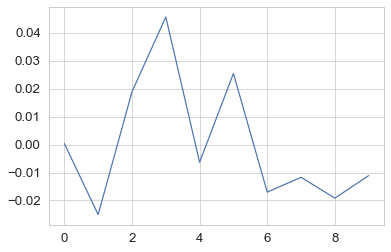

In [13]:
plt.plot(samples["module.linear.bias"][-1, :])

In [14]:
weight = samples[conv_keys[0]][-1]

In [15]:
weight_gaussian = np.random.normal(loc=weight.mean(), scale=weight.std(), size=weight.shape)

In [16]:
weights = {"gaussian": weight_gaussian}
for k in conv_keys:
    weights[k] = samples[k][-1]

In [17]:
weights_reshaped = {name : weight.reshape(weight.shape[0]*weight.shape[1], -1) for name, weight in weights.items()}

In [18]:
weights_all = np.concatenate([samples[k][-1].ravel() for k in conv_keys])

In [19]:
weights_all = {"gaussian": np.random.normal(loc=weights_all.mean(), scale=weights_all.std(), size=weights_all.shape),
              "weights_all": weights_all}

In [162]:
weights.keys()

dict_keys(['gaussian', 'module.conv1.weight', 'module.layer1.0.conv1.weight', 'module.layer1.0.conv2.weight', 'module.layer1.1.conv1.weight', 'module.layer1.1.conv2.weight', 'module.layer2.0.conv1.weight', 'module.layer2.0.conv2.weight', 'module.layer2.1.conv1.weight', 'module.layer2.1.conv2.weight', 'module.layer3.0.conv1.weight', 'module.layer3.0.conv2.weight', 'module.layer3.1.conv1.weight', 'module.layer3.1.conv2.weight', 'module.layer4.0.conv1.weight', 'module.layer4.0.conv2.weight', 'module.layer4.1.conv1.weight', 'module.layer4.1.conv2.weight'])

In [155]:
for k in opt_states.keys():
    w = torch.from_numpy(weights_reshaped[k])
    cov = w.t() @ w / len(w)
    opt_states[k][1]['var'] = cov.diag()

In [165]:
[k for k in samples.keys() if k not in conv_keys and 'bn' not in k]

['module.layer2.0.shortcut.0.weight',
 'module.layer3.0.shortcut.0.weight',
 'module.layer4.0.shortcut.0.weight',
 'module.linear.bias',
 'module.linear.weight',
 'steps',
 'timestamps']

In [176]:
opt_states["module.linear.bias"] = (None, {'var': np.var(samples["module.linear.bias"][-1])})

# Fit kernel model to a set of weights

In [120]:
import gpytorch
kern = gpytorch.kernels.MaternKernel(nu=3/2)

In [127]:
class ConvFitter(torch.nn.Module):
    def __init__(self, kern, weights):
        super().__init__()
        self.inputs = torch.from_numpy(np.mgrid[:3, :3].reshape(2, -1).T.astype(np.float32))
        self.kern = kern
        #self.raw_std = torch.nn.Parameter(torch.randn(9))
        #self.raw_std_constraint = gpytorch.constraints.Positive()
        
        self.register_buffer("weights", torch.from_numpy(weights).to(self.inputs, copy=True))
        
        cov = self.weights.t() @ self.weights / len(self.weights)
        std = cov.diag()**.5
        self.weights /= std
        
        self.register_buffer("std", std)
        self.register_buffer("cov", cov)
                        
    def forward(self):
        #std = self.raw_std_constraint.transform(self.raw_std)
        #std = self.std
        #L = std.unsqueeze(-1) * self.kern(self.inputs).cholesky().evaluate()
        dist = gpytorch.distributions.MultivariateNormal(
            torch.zeros(9), self.kern(self.inputs))
        return dist
    
    def closure(self):
        self.zero_grad()
        dist = self()
        loss = -dist.log_prob(self.weights).sum(0)
        loss.backward()
        return loss

In [ ]:
opt_states = {}

for key in list(weights_reshaped.keys()):
    max_lik = -np.inf
    for name, kern in [("matern_12",gpytorch.kernels.MaternKernel(nu=1/2)),
                       ("matern_32",gpytorch.kernels.MaternKernel(nu=3/2)),
                       ("matern_52",gpytorch.kernels.MaternKernel(nu=5/2)),
                       ("rbf", gpytorch.kernels.RBFKernel())]:
        cf = ConvFitter(kern, weights_reshaped[key])
        optim = torch.optim.LBFGS(cf.parameters())
        for _ in range(10):
            loss = optim.step(cf.closure)
        ls = cf.kern.lengthscale.item()
        lik = -loss.item()
        
        if lik > max_lik:
            max_ls = ls
            max_lik = lik
            max_name = name
            max_sd = cf.state_dict()
            del max_sd["weights"]
    opt_states[key] = (max_name, max_sd)
    print(f"For {key}, {max_name} with ls={max_ls}")

For gaussian, matern_12 with ls=0.0464433878660202
For module.conv1.weight, matern_32 with ls=1.0331251621246338
For module.layer1.0.conv1.weight, matern_32 with ls=0.9995145797729492
For module.layer1.0.conv2.weight, matern_32 with ls=1.071300983428955
For module.layer1.1.conv1.weight, matern_12 with ls=1.0023125410079956
For module.layer1.1.conv2.weight, rbf with ls=0.639470100402832
For module.layer2.0.conv1.weight, matern_32 with ls=1.592911958694458
For module.layer2.0.conv2.weight, rbf with ls=0.8009092211723328
For module.layer2.1.conv1.weight, rbf with ls=0.7830047607421875
For module.layer2.1.conv2.weight, rbf with ls=0.882695734500885
For module.layer3.0.conv1.weight, matern_32 with ls=1.2312480211257935
For module.layer3.0.conv2.weight, rbf with ls=0.7117388844490051
For module.layer3.1.conv1.weight, rbf with ls=0.7902165055274963
For module.layer3.1.conv2.weight, rbf with ls=0.8897801637649536
For module.layer4.0.conv1.weight, matern_32 with ls=1.0552213191986084


In [254]:
# Empirically the variance of the 10 outputs is pretty much the same
opt_states["module.linear.weight"] = (None, {'var': np.var(samples["module.linear.weight"][-1])})

for i in [2, 3, 4]:
    opt_states[f'module.layer{i}.0.shortcut.0.weight'] = (None, {'var': np.var(samples[f'module.layer{i}.0.shortcut.0.weight'][-1])})

In [258]:
#pd.to_pickle(opt_states, "opt_states.pkl.gz")

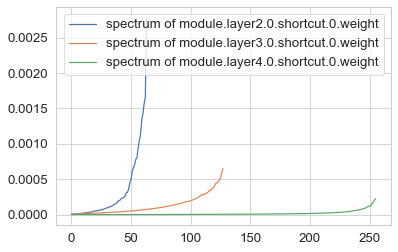

In [247]:
for i in [2, 3, 4]:
    plt.plot(np.linalg.eigvalsh(np.cov(samples[f"module.layer{i}.0.shortcut.0.weight"][-1, :, :, 0, 0], rowvar=False)),
         label=f"spectrum of module.layer{i}.0.shortcut.0.weight")
plt.legend()

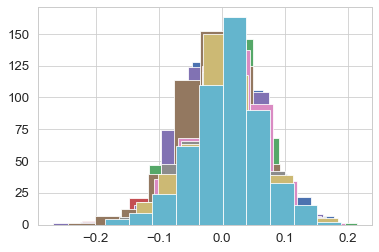

In [226]:
for i in range(10):
    plt.hist(samples["module.linear.weight"][-1, i])

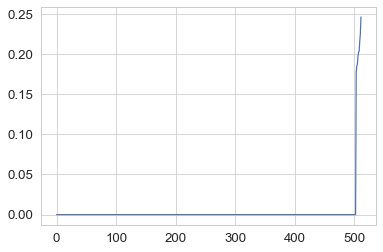

In [220]:
plt.plot(vals)

## Analyse point-wise distribution

In [20]:
weights_all["weights_all"].min(), weights_all["weights_all"].max()

(-0.29718557, 0.26971814)

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: 

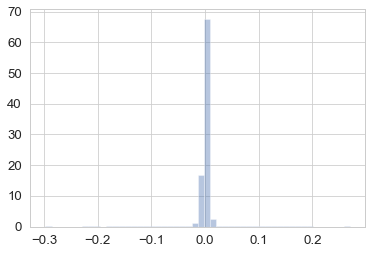

In [21]:
sns.distplot(weights_all["weights_all"])

In [ ]:
plot_weightdist(weights_reshaped, num_bins=50);

In [23]:
torch.distributions.StudentT(df=3, loc=0., scale=1.).sample([3])

tensor([1.7922, 0.1265, 0.2739])

/scratches/huygens/ag919/venv/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


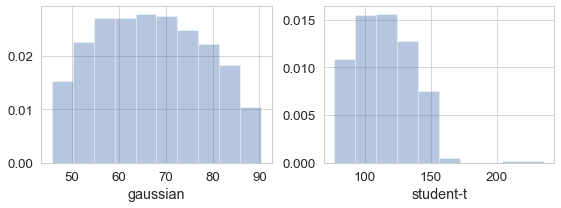

In [24]:
plot_singular_values({
    "gaussian": torch.randn(512, 512*9).numpy(),
    "student-t": torch.distributions.StudentT(df=3, loc=0., scale=1.).sample([512, 512*9]).numpy()});

## Analyse weight correlations

In [30]:
import gpytorch

In [38]:
gpytorch.kernels.MaternKernel(nu=3/2, )

Help on class MaternKernel in module gpytorch.kernels.matern_kernel:

class MaternKernel(gpytorch.kernels.kernel.Kernel)
 |  MaternKernel(nu=2.5, **kwargs)
 |  
 |  Computes a covariance matrix based on the Matern kernel
 |  between inputs :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`:
 |  
 |  .. math::
 |  
 |     \begin{equation*}
 |        k_{\text{Matern}}(\mathbf{x_1}, \mathbf{x_2}) = \frac{2^{1 - \nu}}{\Gamma(\nu)}
 |        \left( \sqrt{2 \nu} d \right) K_\nu \left( \sqrt{2 \nu} d \right)
 |     \end{equation*}
 |  
 |  where
 |  
 |  * :math:`d = (\mathbf{x_1} - \mathbf{x_2})^\top \Theta^{-1} (\mathbf{x_1} - \mathbf{x_2})`
 |    is the distance between
 |    :math:`x_1` and :math:`x_2` scaled by the :attr:`lengthscale` parameter :math:`\Theta`.
 |  * :math:`\nu` is a smoothness parameter (takes values 1/2, 3/2, or 5/2). Smaller values are less smooth.
 |  * :math:`K_\nu` is a modified Bessel function.
 |  
 |  There are a few options for the lengthscale parameter :math:`\Theta

In [29]:
weights_reshaped['module.layer2.0.conv1.weight'].shape

(262144, 9)

In [75]:
the_cov = np.cov(weights_reshaped['module.layer3.1.conv2.weight'], rowvar=False)

In [76]:
kern = gpytorch.kernels.MaternKernel(nu=3/2)
kern.lengthscale = 1.4

In [77]:
the_corr=  the_cov / np.diag(the_cov)[:, None]**.5 / np.diag(the_cov)[None, :]**.5

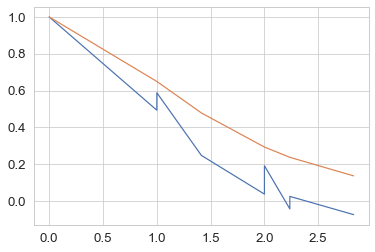

In [78]:
origin_y = origin_x = 0.
vals = []
for y in range(3):
    for x in range(3):
        dist = ((y - origin_y)**2 + (x - origin_x)**2)**.5
        
        kern_val = kern(torch.tensor([origin_x, origin_y]).unsqueeze(0), torch.tensor([x, y]).unsqueeze(0)).evaluate().item()
        
        vals.append((dist, the_corr[0, x + y*3], kern_val))
        
x, y_empirical, y_kernel = map(np.array, zip(*sorted(vals)))
plt.plot(x, y_empirical)
plt.plot(x, y_kernel)

In [80]:
weights = torch.from_numpy(weights_reshaped['module.layer3.1.conv2.weight'])
mean = weights.mean(0)

X = torch.arange(3).expand((3, 3))
positions = torch.stack([X, X.t()], dim=-1).reshape((3*3, 2)).to(torch.float32)


torch.Size([65536, 9])

In [93]:
positions

tensor([[0., 0.],
        [1., 0.],
        [2., 0.],
        [0., 1.],
        [1., 1.],
        [2., 1.],
        [0., 2.],
        [1., 2.],
        [2., 2.]])

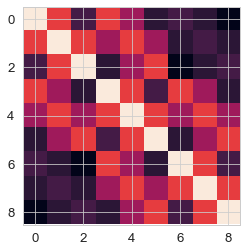

In [95]:
plt.imshow(kern(positions).evaluate().detach().numpy())

In [96]:
gpytorch.distributions.MultivariateNormal(, kern(positions)).covariance_matrix

AttributeError: 'dict' object has no attribute 'mean'

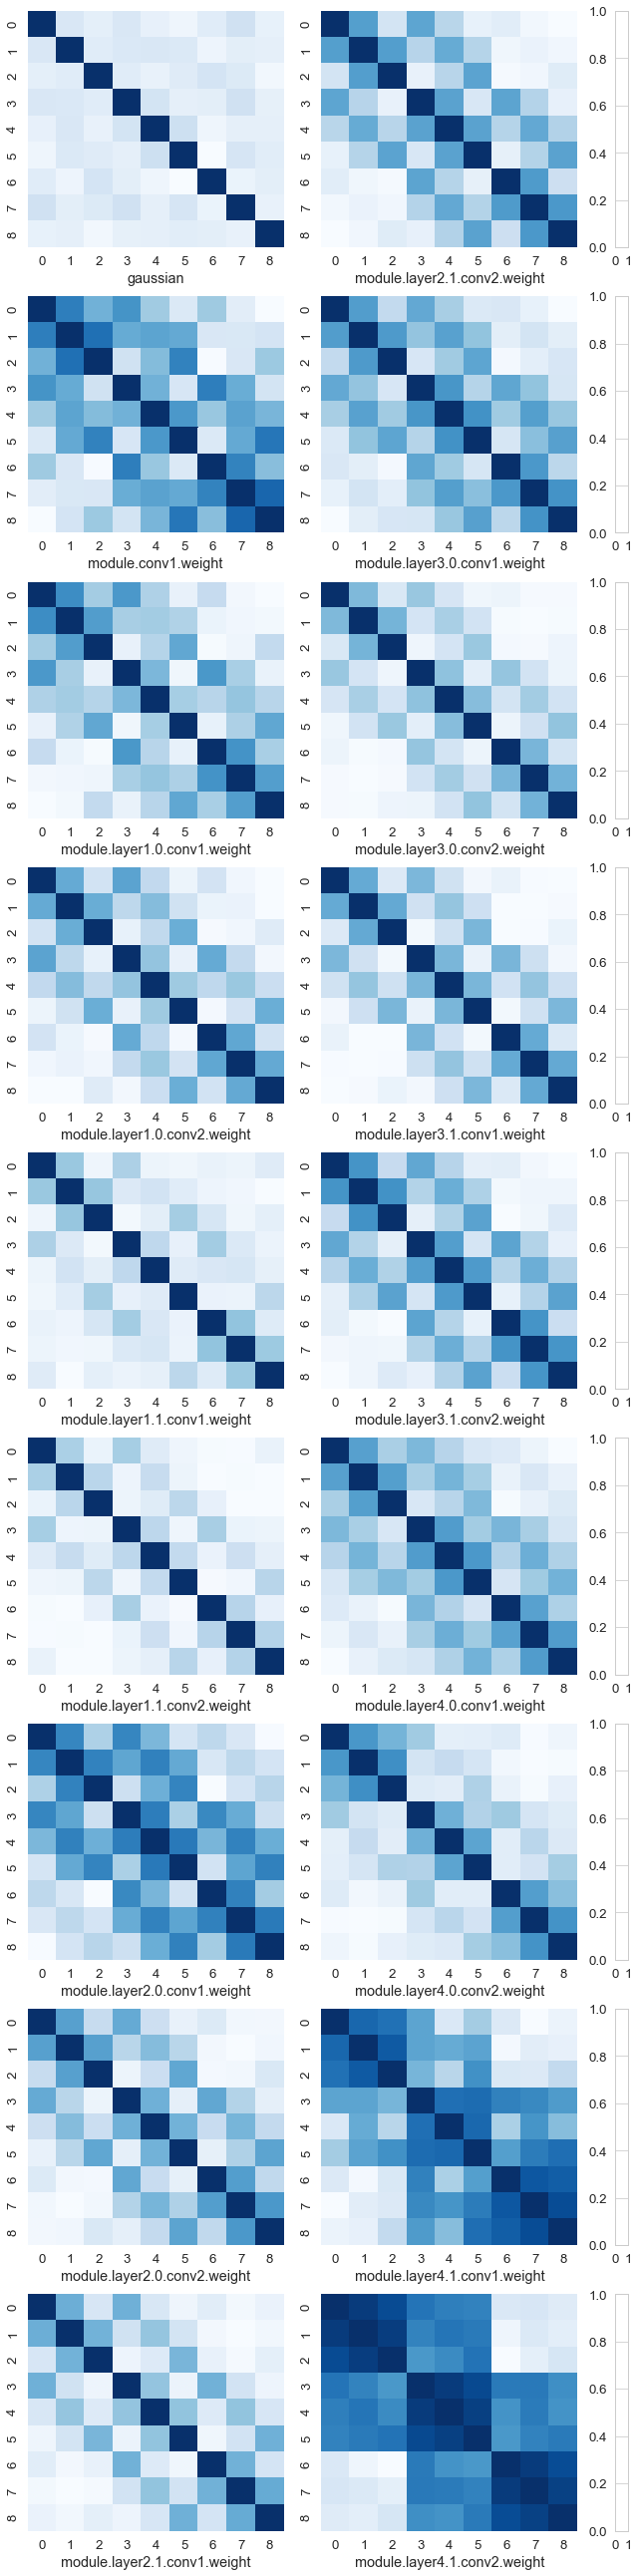

In [25]:
plot_covariance(weights_reshaped, False, correlation=True);

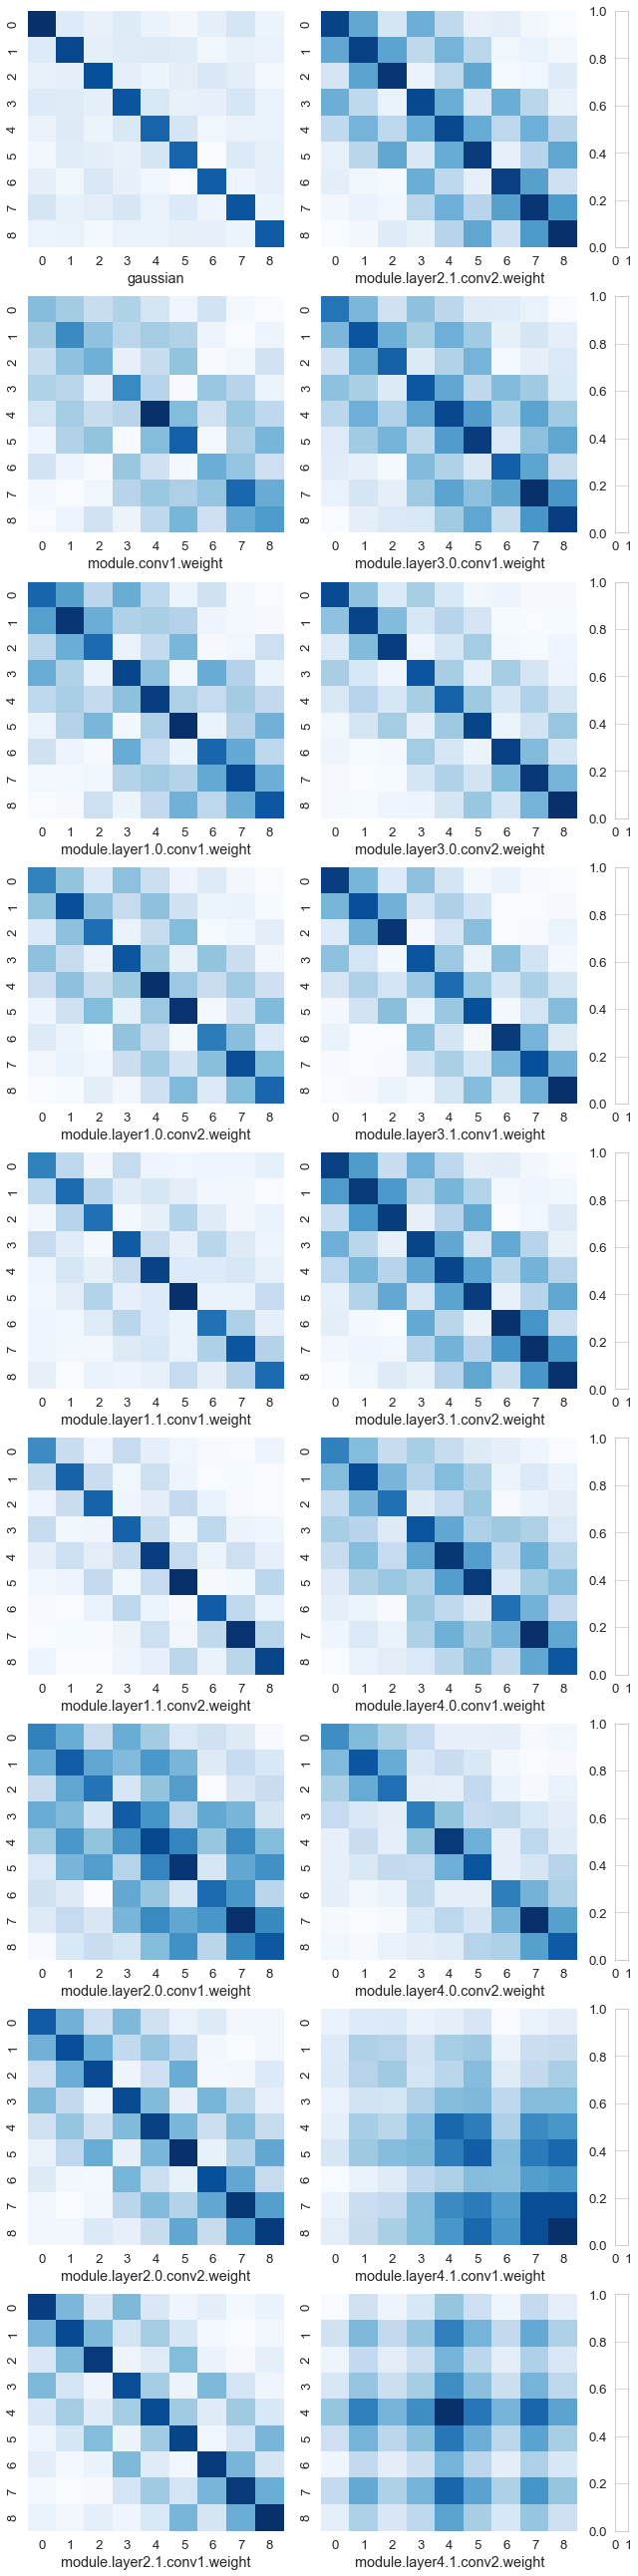

In [26]:
plot_covariance(weights_reshaped, False);

MemoryError: Unable to allocate 32.0 GiB for an array with shape (65536, 65536) and data type float64

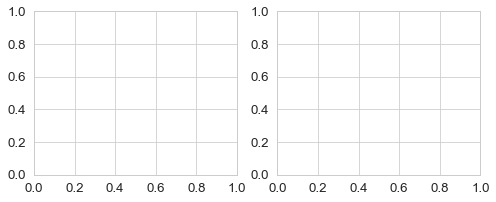

In [27]:
plot_covar_offdiagonals(weights_reshaped, True);

In [ ]:
plot_covar_offdiagonals(weights_reshaped, False);

## Analyse singular values

In [ ]:
plot_singular_values(weights_reshaped);

## Run analyses for all layers

In [ ]:
exp_name = "200918_mnist_cnn"

In [ ]:
for config_file in glob(f"../results/{exp_name}/*/config.json"):
    with open(config_file) as infile:
        config = pd.Series(json.load(infile))
    with open(config_file[:-11] + "run.json") as infile:
        result = pd.Series(json.load(infile)["result"], dtype=np.float32)
    run_data = pd.concat([config, result])
    if run_data["weight_prior"] == "improper" and run_data["temperature"] == 0.:
        print(run_data["weight_prior"], run_data["temperature"], run_data["weight_scale"], config_file)

In [ ]:
samples_file = f"../results/{exp_name}/20/samples.pt"

In [ ]:
samples = load_samples(samples_file)

In [ ]:
last_sample = {param: weights[-1] for param, weights in samples.items()}  # take the last sample of the chain

In [ ]:
generate_all_figures(last_sample, exp_name, cnn=True)

In [ ]:
from bnn_priors.exp_utils import get_model

model = get_model(x_train=None, y_train=None, model="resnet18", width=None, depth=None,
                  weight_prior="improper", weight_loc=0., weight_scale=1.,
                  bias_prior="improper", bias_loc=0., bias_scale=1.,
                  batchnorm=True, weight_prior_params={}, bias_prior_params={})

In [ ]:
model

In [ ]:
from bnn_priors.models.preact_resnet import PreActResNet18
net = PreActResNet18()

In [ ]:
net

In [ ]:
[name for name, _ in model.named_parameters() if ("weight_prior.p" in name or "bias_prior.p" in name)]